In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit

In [3]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\

exp_id='2018_02_09_11_35_21_Microwave Freq scan'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)

In [4]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
np.squeeze(retention['retention'])

In [13]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	0.01	retention:0.015 +- 0.007
ivar:	0.01	retention:0.009 +- 0.007
ivar:	0.01	retention:0.026 +- 0.007
ivar:	0.01	retention:0.000 +- 0.007
ivar:	0.01	retention:0.000 +- 0.007
ivar:	0.01	retention:0.000 +- 0.005
ivar:	0.01	retention:0.000 +- 0.005
ivar:	0.01	retention:0.013 +- 0.005
ivar:	0.01	retention:0.000 +- 0.005
ivar:	0.01	retention:0.042 +- 0.005
ivar:	0.01	retention:0.065 +- 0.022
ivar:	0.01	retention:0.088 +- 0.022
ivar:	0.01	retention:0.171 +- 0.022
ivar:	0.01	retention:0.100 +- 0.022
ivar:	0.01	retention:0.100 +- 0.022
ivar:	0.01	retention:0.324 +- 0.038
ivar:	0.01	retention:0.355 +- 0.038
ivar:	0.01	retention:0.427 +- 0.038
ivar:	0.01	retention:0.261 +- 0.038
ivar:	0.01	retention:0.200 +- 0.038
ivar:	0.01	retention:0.486 +- 0.038
ivar:	0.01	retention:0.619 +- 0.038
ivar:	0.01	retention:0.724 +- 0.038
ivar:	0.01	retention:0.655 +- 0.038
ivar:	0.01	retention:0.650 +- 0.038
ivar:	0.01	retention:0.692 +- 0.039
ivar:	0.01	retention:0.687 +- 0.039
ivar:	0.01	retention:0.803 +

In [14]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

<IPython.core.display.Javascript object>


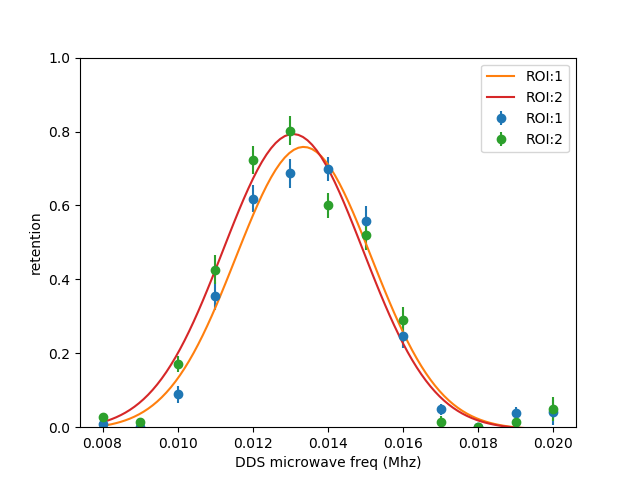

ROI:1, amplitude : 0.764577680348, freq: 0.0133514209878 , sigma:0.0025616425307, offset:-0.00619229199654
ROI:2, amplitude : 0.79923683894, freq: 0.0130698041537 , sigma:0.00263522622894, offset:-0.00606715403257


In [24]:
fig, ax = plt.subplots()
fit_guesses=[0.8,0.013,0.005,0]
fitted_parameters=[]
for roi in [1,2]:
    
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o')
    fit = curve_fit(gaussian,data,reten,fit_guesses)
    print "ROI:{}, amplitude : {}, freq: {} , sigma:{}, offset:{}".format(roi,fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    fitted_parameters.append(fit[0])
    #print fit[0]
    xarray=np.linspace(np.min(data),np.max(data),100)
    yfit=gaussian(xarray, np.float(fit[0][0]),np.float(fit[0][1]),np.float(fit[0][2]),np.float(fit[0][3]))
    plt.plot(xarray,yfit,label="ROI:{}".format(roi))

plt.show()
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()

In [23]:
print np.mean([0.0133514209878,0.0130698041537])

0.0132106125707
